In [1]:
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import glob
import os
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter,LatitudeFormatter
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable

## Defintions of climate indices

Defintions from:

Defrance, D. (2019). Dataset of global extreme climatic indices due to an acceleration of ice sheet melting during the 21st century. Data in brief, 27, 104585.

In [ ]:
def TNmin(da):
    # Calculate annual minimum temperature
    # Input: daily minimum temperature
    n_lats = len(da.lat)
    n_lons = len(da.lon)
    n_years = int(len(da.time)/365)

    annual_minimum_temperatures = np.zeros((n_lats, n_lons, n_years))

    for lat in range(n_lats):
        print(lat, "of 8")
        for lon in range(n_lons):
            for year in range(n_years):
                da_i = da.isel(lat=lat, lon=lon, time=slice(year*365,(year+1)*365))
                TNmin = min(da_i.values)

                annual_minimum_temperatures[lat, lon, year] = TNmin
    
    return annual_minimum_temperatures



def TXmax(da):
    # Calculate annual maximum temperature
    # Input: daily maximum temperature
    n_lats = len(da.lat)
    n_lons = len(da.lon)
    n_years = int(len(da.time)/365)

    annual_maximum_temperatures = np.zeros((n_lats, n_lons, n_years))

    for lat in range(n_lats):
        for lon in range(n_lons):
            for year in range(n_years):
                da_i = da.isel(lat=lat, lon=lon, time=slice(year*365,(year+1)*365))
                TXmax = max(da_i.values)

                annual_maximum_temperatures[lat, lon, year] = TXmax
    
    return annual_maximum_temperatures

def FD(da):
    # Calculate number of frost days
    # Input: daily minimum temperature
    n_lats = len(da.lat)
    n_lons = len(da.lon)
    n_years = int(len(da.time)/365)

    n_frost_days = np.zeros((n_lats, n_lons, n_years))

    for lat in range(n_lats):
        for lon in range(n_lons):
            for year in range(n_years):
                da_i = da.isel(lat=lat, lon=lon, time=slice(year*365,(year+1)*365))
                FD = int(np.sum(da_i.values < 273.15))
                n_frost_days[lat, lon, year] = FD
    
    return n_frost_days

def ID(da):
    # Calculate number of icing days
    # Input: daily maximum temperature
    n_lats = len(da.lat)
    n_lons = len(da.lon)
    n_years = int(len(da.time)/365)

    n_icing_days = np.zeros((n_lats, n_lons, n_years))

    for lat in range(n_lats):
        for lon in range(n_lons):
            for year in range(n_years):
                da_i = da.isel(lat=lat, lon=lon, time=slice(year*365,(year+1)*365))
                ID = int(np.sum(da_i.values < 273.15))
                n_icing_days[lat, lon, year] = ID
    
    return n_icing_days

def TR(da):
    # Calculate number of tropical nights
    # Input: daily minimum temperature
    n_lats = len(da.lat)
    n_lons = len(da.lon)
    n_years = int(len(da.time)/365)

    n_tropical_nights = np.zeros((n_lats, n_lons, n_years))

    for lat in range(n_lats):
        for lon in range(n_lons):
            for year in range(n_years):
                da_i = da.isel(lat=lat, lon=lon, time=slice(year*365,(year+1)*365))
                TR = int(np.sum(da_i.values > 293.15))
                n_tropical_nights[lat, lon, year] = TR
    
    return n_tropical_nights

def SU(da):
    # Calculate number of summer days
    # Input: daily maximum temperature
    n_lats = len(da.lat)
    n_lons = len(da.lon)
    n_years = int(len(da.time)/365)

    n_summer_days = np.zeros((n_lats, n_lons, n_years))

    for lat in range(n_lats):
        for lon in range(n_lons):
            for year in range(n_years):
                da_i = da.isel(lat=lat, lon=lon, time=slice(year*365,(year+1)*365))
                SU = int(np.sum(da_i.values > 298.15))
                n_summer_days[lat, lon, year] = SU
    
    return n_summer_days

def WSDI(da, TXin90):
    # Calculate well spell duration index
    # Input: daily maximum temperature and 90th percentile historical maximum temperature
    n_lats = len(da.lat)
    n_lons = len(da.lon)
    n_years = int(len(da.time)/365)

    warm_spell_duration_index = np.zeros((n_lats, n_lons, n_years))
    time_threshold = 6

    for lat in range(n_lats):
        for lon in range(n_lons):
            for year in range(n_years):
                da_i = da.isel(lat=lat, lon=lon, time=slice(year*365,(year+1)*365))
                TXin90_i = TXin90[lat, lon, :]
                non_warm_days = [temp < threshold for temp, threshold in zip(da_i.values, TXin90)]
                non_warm_days_idx = np.where(non_warm_days)[0]
                WSDI = int(np.sum(np.diff(non_warm_days_idx) >= time_threshold))

                warm_spell_duration_index[lat, lon, year] = WSDI
    
    return warm_spell_duration_index

def CWDI(da, TNin10):
    # Calculate cold wave duration index
    # Input: daily minimum temperature and 10th percentile historical minimum temperature
    n_lats = len(da.lat)
    n_lons = len(da.lon)
    n_years = int(len(da.time)/365)

    cold_wave_duration_index = np.zeros((n_lats, n_lons, n_years))
    time_threshold = 6

    for lat in range(n_lats):
        for lon in range(n_lons):
            for year in range(n_years):
                da_i = da.isel(lat=lat, lon=lon, time=slice(year*365,(year+1)*365))
                TNin10_i = TNin10[lat, lon, :]
                non_cold_days = [temp > threshold for temp, threshold in zip(da_i.values, TNin10)]
                non_cold_days_idx = np.where(non_cold_days)[0]
                CWDI = int(np.sum(np.diff(non_cold_days_idx) >= time_threshold))
                cold_wave_duration_index[lat, lon, year] = CWDI
    
    return cold_wave_duration_index


## Loading relevant climate variables from different models, areas and time periods

CMIP6 data downloaded from https://esgf-node.ipsl.upmc.fr/search/cmip6-ipsl/

In [197]:
# Define dataset specifics

model_scenario_name = 'NorESM2-LM_ssp126' # Choose a model and SSP scenario
area_name = 'norway' # Choose an area

# Defines start and end of time slice by picking 20 years before and 20 years after abrupt SPG cooling
if model_scenario_name == 'NorESM2-LM_ssp126':
    start_time = '2015-01-01'; end_time = '2055-01-01'
    time_array = np.arange(2015, 2055, 1)
elif model_scenario_name == 'CESM2-WACCM_ssp126':
    start_time = '2020-01-01'; end_time = '2060-01-01'
    time_array = np.arange(2020, 2060, 1)
elif model_scenario_name == 'MRI-ESM2_ssp245':
    start_time = '2020-01-01'; end_time = '2060-01-01'
    time_array = np.arange(2020, 2060, 1)
else:
    print("This dataset is not considered in the current study, but can be added to the analysis")

if area_name == 'norway':
    southern_lat = 57; northern_lat = 72
    western_lon = 2.5; eastern_lon = 33
elif area_name == 'germany': #UPDATE
    southern_lat = 57; northern_lat = 72
    western_lon = 2.5; eastern_lon = 33
elif area_name == 'global':
    southern_lat = -90; northern_lat = 90
    western_lon = 0; eastern_lon = 360
else:
    print("This area is not predefined in the current study, but can be added to the analysis")

data_folder = '../CMIP6_data/' # Folder where downloaded CMIP6 data is stored
save_folder = '../climatic_indices/' # Folder where climate indices should be saved
os.makedirs(save_folder, exist_ok=True) 


# Load maximum daily temperature data

files = glob.glob(data_folder+'tasmax_day_'+model_scenario_name+'*')
files.sort()
tasmax = xr.open_mfdataset(files)

tmax = tasmax.tasmax.sel(lat=slice(southern_lat, northern_lat), 
                        lon=slice(western_lon, eastern_lon), 
                        time=slice(start_time, end_time))
tmax.load()

# Load minimum daily temperature data

files = glob.glob(data_folder+'tasmin_day_'+model_scenario_name+'*')
files.sort()
tasmin = xr.open_mfdataset(files)

tmin = tasmin.tasmin.sel(lat=slice(southern_lat, northern_lat), 
                        lon=slice(western_lon, eastern_lon), 
                        time=slice(start_time, end_time))

tmin.load()



<xarray.DataArray 'tasmin' (time: 14601, lat: 8, lon: 13)> Size: 6MB
array([[[273.3614 , 271.6733 , 269.38773, ..., 262.42883, 262.4719 ,
         262.62924],
        [273.06244, 269.13956, 259.00912, ..., 268.25894, 264.5443 ,
         262.66522],
        [273.70053, 268.65912, 256.0441 , ..., 262.61197, 263.0432 ,
         261.72565],
        ...,
        [271.24426, 272.30853, 272.85446, ..., 258.11313, 256.91815,
         256.5043 ],
        [269.452  , 270.92758, 271.97177, ..., 261.16495, 262.1215 ,
         264.3928 ],
        [268.0876 , 270.1765 , 269.54572, ..., 268.09714, 269.542  ,
         269.95227]],

       [[273.7263 , 272.46072, 270.1581 , ..., 262.43698, 261.91577,
         262.4874 ],
        [273.6518 , 270.5034 , 259.78983, ..., 268.45425, 263.24603,
         258.91605],
        [274.24197, 270.16592, 258.59772, ..., 261.72455, 257.24796,
         254.29459],
...
        [272.28632, 274.36877, 274.70578, ..., 260.6846 , 262.0461 ,
         265.70886],
        [269.69995, 272.24713, 273.79416, ..., 257.1634 , 263.9845 ,
         267.63345],
        [267.2852 , 270.2222 , 272.7994 , ..., 269.58737, 269.53616,
         269.14706]],

       [[277.49347, 276.84662, 276.51312, ..., 265.92093, 263.48846,
         259.90463],
        [277.13364, 274.57626, 268.16193, ..., 267.33005, 260.6958 ,
         261.84457],
        [275.71158, 271.39877, 260.522  , ..., 262.24658, 261.28616,
         254.01425],
        ...,
        [272.51358, 274.58426, 274.1952 , ..., 262.1167 , 262.2105 ,
         258.75092],
        [271.5211 , 274.18466, 274.4293 , ..., 262.7714 , 261.9295 ,
         265.48013],
        [270.50217, 273.80774, 274.00595, ..., 269.3773 , 269.81058,
         269.52658]]], dtype=float32)
Coordinates:
  * time     (time) object 117kB 2015-01-01 12:00:00 ... 2055-01-01 12:00:00
  * lat      (lat) float64 64B 57.79 59.68 61.58 63.47 65.37 67.26 69.16 71.05
  * lon      (lon) float64 104B 2.5 5.0 7.5 10.0 12.5 ... 25.0 27.5 30.0 32.5
    height   float64 8B 2.0
Attributes:
    standard_name:  air_temperature
    long_name:      Daily Minimum Near-Surface Air Temperature
    comment:        minimum near-surface (usually, 2 meter) air temperature (...
    units:          K
    original_name:  TREFHTMN
    cell_methods:   area: mean time: minimum
    cell_measures:  area: areacella
    history:        2019-12-06T14:55:16Z altered by CMOR: Treated scalar dime...

## Calculate climatic indices

In [ ]:
# Choose which variable to calculate

variable_name_list = ['TNmin', 'TXmax', 'FD', 'ID', 'TR', 'SU']
unit_list = ['Kelvin', 'Kelvin', 'days', 'days', 'days', 'days']
description_list = ['Annual minimum temperature', 'Annual maximum temperature', 
                    'Number of frost days', 'Number of icing days', 
                    'Number of tropical nights', 'Number of summer days']

input_values_list = [tmin, tmax, tmin, tmax, tmin, tmax]
index_function_list = [TNmin, TXmax, FD, ID, TR, SU]

# Save data as netcdf file

for variable_name, unit, description, input_values, index_function in zip(variable_name_list, unit_list, description_list, input_values_list, index_function_list):
    print(variable_name)
    values = index_function(input_values)
    
    ds = xr.Dataset(
        data_vars=dict(
            variable=(["lat", "lon", "time"], values)
        ),
        coords=dict(
            lat=input_values.lat.values,
            lon=input_values.lon.values,
            time=time_array,
        ),
    )

    ds.time.attrs['units'] = 'year'
    ds.lat.attrs['description'] = 'latitude'
    ds.lon.attrs['description'] = 'longitude'
    ds = ds.rename_vars(dict(variable=variable_name))
    ds[variable_name].attrs['units'] = unit
    ds[variable_name].attrs['description'] = description

    ds.to_netcdf(save_folder+variable_name+'_'+area_name+'_'+model_scenario_name+'.nc')
    print('Dataset saved')

TNmin
0 of 8
1 of 8
2 of 8
3 of 8
4 of 8
5 of 8
6 of 8
7 of 8
Dataset saved
TXmax
0 of 8
1 of 8
2 of 8
3 of 8
4 of 8
5 of 8
6 of 8
7 of 8
Dataset saved
FD
0 of 8
1 of 8
2 of 8
3 of 8
4 of 8
5 of 8
6 of 8
7 of 8
Dataset saved
ID
0 of 8
1 of 8
2 of 8
3 of 8
4 of 8
5 of 8
6 of 8
7 of 8
Dataset saved
TR
0 of 8
1 of 8
2 of 8
3 of 8
4 of 8
5 of 8
6 of 8
7 of 8
Dataset saved
SU
0 of 8
1 of 8
2 of 8
3 of 8
4 of 8
5 of 8
6 of 8
7 of 8
Dataset saved


In [84]:
variable_name = 'SU'
ds = xr.open_dataset(save_folder+variable_name+'_'+area_name+'_'+model_scenario_name+'.nc', 
                    decode_timedelta={variable_name : False})
print(ds)
ds[variable_name].values

<xarray.Dataset> Size: 34kB
Dimensions:  (lat: 8, lon: 13, time: 40)
Coordinates:
  * lat      (lat) float64 64B 57.79 59.68 61.58 63.47 65.37 67.26 69.16 71.05
  * lon      (lon) float64 104B 2.5 5.0 7.5 10.0 12.5 ... 25.0 27.5 30.0 32.5
  * time     (time) int64 320B 2015 2016 2017 2018 2019 ... 2051 2052 2053 2054
Data variables:
    SU       (lat, lon, time) float64 33kB ...


array([[[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        ...,
        [20.,  8., 23., ..., 37., 33., 23.],
        [18.,  7., 27., ..., 39., 39., 31.],
        [16., 13., 25., ..., 43., 39., 34.]],

       [[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  1.,  3., 11.],
        ...,
        [ 1.,  0.,  0., ...,  1.,  0.,  0.],
        [15.,  7., 13., ..., 35., 31., 17.],
        [14.,  7., 14., ..., 33., 28., 20.]],

       [[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  1.,  3.],
        ...,
        [11.,  5.,  8., ..., 25., 15., 12.],
        [ 8.,  4.,  3., ..., 21., 19.,  9.],
        [11.,  5.,  4., ..., 23., 22.,  9.]],

       ...,

       [[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.

## Calculate historical temperature distribution

In [ ]:
# Define dataset specifics

model_scenario_name = 'NorESM2-LM_historical' # Choose a model and SSP scenario
area_name = 'norway' # Choose an area

# Define reference period
if model_scenario_name == 'NorESM2-LM_historical' or model_scenario_name == 'CESM2-WACCM_historical' or model_scenario_name == 'MRI-ESM2_historical':
    start_time = '1976-01-01'; end_time = '2006-01-01'
    time_array = np.arange(1976, 2006, 1)
else:
    print("This dataset is not considered in the current study, but can be added to the analysis")

if area_name == 'norway':
    southern_lat = 57; northern_lat = 72
    western_lon = 2.5; eastern_lon = 33
elif area_name == 'germany':
    southern_lat = 46.5; northern_lat = 55.5
    western_lon = 5; eastern_lon = 15
elif area_name == 'global':
    southern_lat = -90; northern_lat = 90
    western_lon = 0; eastern_lon = 360
else:
    print("This area is not predefined in the current study, but can be added to the analysis")

data_folder = '../CMIP6_data/' # Folder where downloaded CMIP6 data is stored
save_folder = '../climatic_indices/' # Folder where climate indices should be saved
os.makedirs(save_folder, exist_ok=True) 


# Load maximum daily temperature data

files = glob.glob(data_folder+'tasmax_day_'+model_scenario_name+'*')
files.sort()
tasmax_hist = xr.open_mfdataset(files)

tmax_hist = tasmax_hist.tasmax.sel(lat=slice(southern_lat, northern_lat), 
                        lon=slice(western_lon, eastern_lon), 
                        time=slice(start_time, end_time))
tmax_hist.load()

# Load minimum daily temperature data

files = glob.glob(data_folder+'tasmin_day_'+model_scenario_name+'*')
files.sort()
tasmin_hist = xr.open_mfdataset(files)

tmin_hist = tasmin_hist.tasmin.sel(lat=slice(southern_lat, northern_lat), 
                        lon=slice(western_lon, eastern_lon), 
                        time=slice(start_time, end_time))

tmin_hist.load()

<xarray.DataArray 'tasmin' (time: 10951, lat: 8, lon: 13)> Size: 5MB
array([[[280.2594 , 278.4402 , 274.6689 , ..., 264.9339 , 262.10233,
         261.66052],
        [279.38586, 276.25873, 267.72333, ..., 268.86063, 269.0037 ,
         268.9427 ],
        [277.79193, 274.88672, 264.95966, ..., 258.0112 , 256.67972,
         256.07812],
        ...,
        [273.14224, 273.23325, 272.92316, ..., 257.60635, 256.22678,
         256.19305],
        [270.68655, 271.0907 , 271.44952, ..., 259.15985, 259.76782,
         264.15802],
        [269.0929 , 269.1505 , 269.3433 , ..., 265.61218, 266.32684,
         267.001  ]],

       [[279.7576 , 278.42654, 274.12177, ..., 260.45197, 256.16983,
         253.55473],
        [279.97433, 276.48624, 266.39752, ..., 263.42383, 255.93417,
         251.7195 ],
        [279.0963 , 275.60934, 264.16464, ..., 254.604  , 252.95699,
         250.91966],
...
        [278.30353, 279.6379 , 280.43018, ..., 270.27917, 266.27817,
         264.1449 ],
        [274.6036 , 276.43408, 277.61667, ..., 268.98047, 266.61615,
         267.12323],
        [268.83286, 270.59714, 271.9438 , ..., 273.6013 , 272.66458,
         271.92365]],

       [[280.73743, 279.80524, 278.8362 , ..., 273.47476, 273.0896 ,
         272.99347],
        [281.17575, 279.60837, 274.92795, ..., 274.72644, 273.7432 ,
         273.17462],
        [281.87927, 280.193  , 274.48615, ..., 273.37714, 273.02377,
         272.92993],
        ...,
        [274.96332, 276.0986 , 276.68417, ..., 273.28912, 272.5309 ,
         271.4855 ],
        [270.3642 , 271.7791 , 272.85065, ..., 268.08966, 267.97708,
         269.692  ],
        [268.03928, 269.60312, 270.70627, ..., 271.14407, 271.61615,
         271.99753]]], dtype=float32)
Coordinates:
  * time     (time) object 88kB 1976-01-01 12:00:00 ... 2006-01-01 12:00:00
  * lat      (lat) float64 64B 57.79 59.68 61.58 63.47 65.37 67.26 69.16 71.05
  * lon      (lon) float64 104B 2.5 5.0 7.5 10.0 12.5 ... 25.0 27.5 30.0 32.5
    height   float64 8B 2.0
Attributes:
    standard_name:  air_temperature
    long_name:      Daily Minimum Near-Surface Air Temperature
    comment:        minimum near-surface (usually, 2 meter) air temperature (...
    units:          K
    original_name:  TREFHTMN
    cell_methods:   area: mean time: minimum
    cell_measures:  area: areacella
    history:        2019-08-15T18:26:01Z altered by CMOR: Treated scalar dime...

In [ ]:
def calculate_quantiles(da, quantile, window=5):
    # Calculate a certain percentile centered on certain window
    n_lats = len(da.lat)
    n_lons = len(da.lon)

    yearly_quantiles = np.zeros((n_lats, n_lons, 365))

    for lat in range(n_lats):
        for lon in range(n_lons):
            da_i = da.isel(lat=lat, lon=lon)
            grouped = da_i.groupby("time.dayofyear")
            quant = grouped.quantile(quantile)
            yearly_quantiles[lat, lon, :] = quant.rolling(dayofyear=window, center=True, min_periods=1).mean()
    
    return yearly_quantiles

TXin90 = calculate_quantiles(tmax_hist, 0.9)
print("90th percentile maximum temperature calculated")

TNin10 = calculate_quantiles(tmin_hist, 0.1)
print("10th percentile minimum temperature calculated")

## Calculate cold and warm spell indexes

In [198]:
# Choose which variable to calculate

variable_name_list = ['WSDI', 'CWDI']
unit_list = ['days', 'days']
description_list = ['Warm spell duration index', 'Cold wave duration index']

input_values_list = [[tmax, TXin90], [tmin, TNin10]]
index_function_list = [WSDI, CWDI]

# Save data as netcdf file

for variable_name, unit, description, input_values, index_function in zip(variable_name_list, unit_list, description_list, input_values_list, index_function_list):
    print(variable_name)
    values = index_function(input_values[0], input_values[1])
    
    ds = xr.Dataset(
        data_vars=dict(
            variable=(["lat", "lon", "time"], values)
        ),
        coords=dict(
            lat=input_values[0].lat.values,
            lon=input_values[0].lon.values,
            time=time_array,
        ),
    )

    ds.time.attrs['units'] = 'year'
    ds.lat.attrs['description'] = 'latitude'
    ds.lon.attrs['description'] = 'longitude'
    ds = ds.rename_vars(dict(variable=variable_name))
    ds[variable_name].attrs['units'] = unit
    ds[variable_name].attrs['description'] = description

    ds.to_netcdf(save_folder+variable_name+'_'+area_name+'_'+model_scenario_name+'.nc')
    print('Dataset saved')

WSDI


Dataset saved
CWDI
Dataset saved


[[[273.36138916 270.42788696 271.62374878 ... 271.97302246 272.06973267
   272.5010376 ]
  [271.52215576 268.55331421 269.55401611 ... 272.09066772 269.31851196
   269.17437744]
  [268.53897095 267.23657227 267.92901611 ... 269.10839844 267.43347168
   266.20944214]
  ...
  [250.44184875 256.49298096 260.36749268 ... 255.34822083 256.96673584
   246.85501099]
  [247.71676636 251.67422485 254.23680115 ... 254.62107849 252.44764709
   242.11798096]
  [246.80976868 249.03033447 255.62637329 ... 250.64564514 250.60510254
   240.90519714]]

 [[270.90490723 267.07681274 271.22628784 ... 271.23376465 269.85366821
   271.41964722]
  [266.20846558 262.94909668 267.7869873  ... 269.71856689 265.37902832
   265.87121582]
  [252.65568542 251.89724731 256.06546021 ... 251.26124573 254.3026123
   248.82196045]
  ...
  [251.06225586 250.94659424 260.84817505 ... 260.19033813 259.23651123
   243.21673584]
  [243.53443909 246.26626587 253.0798645  ... 253.44650269 252.77145386
   239.77554321]
  [246.4

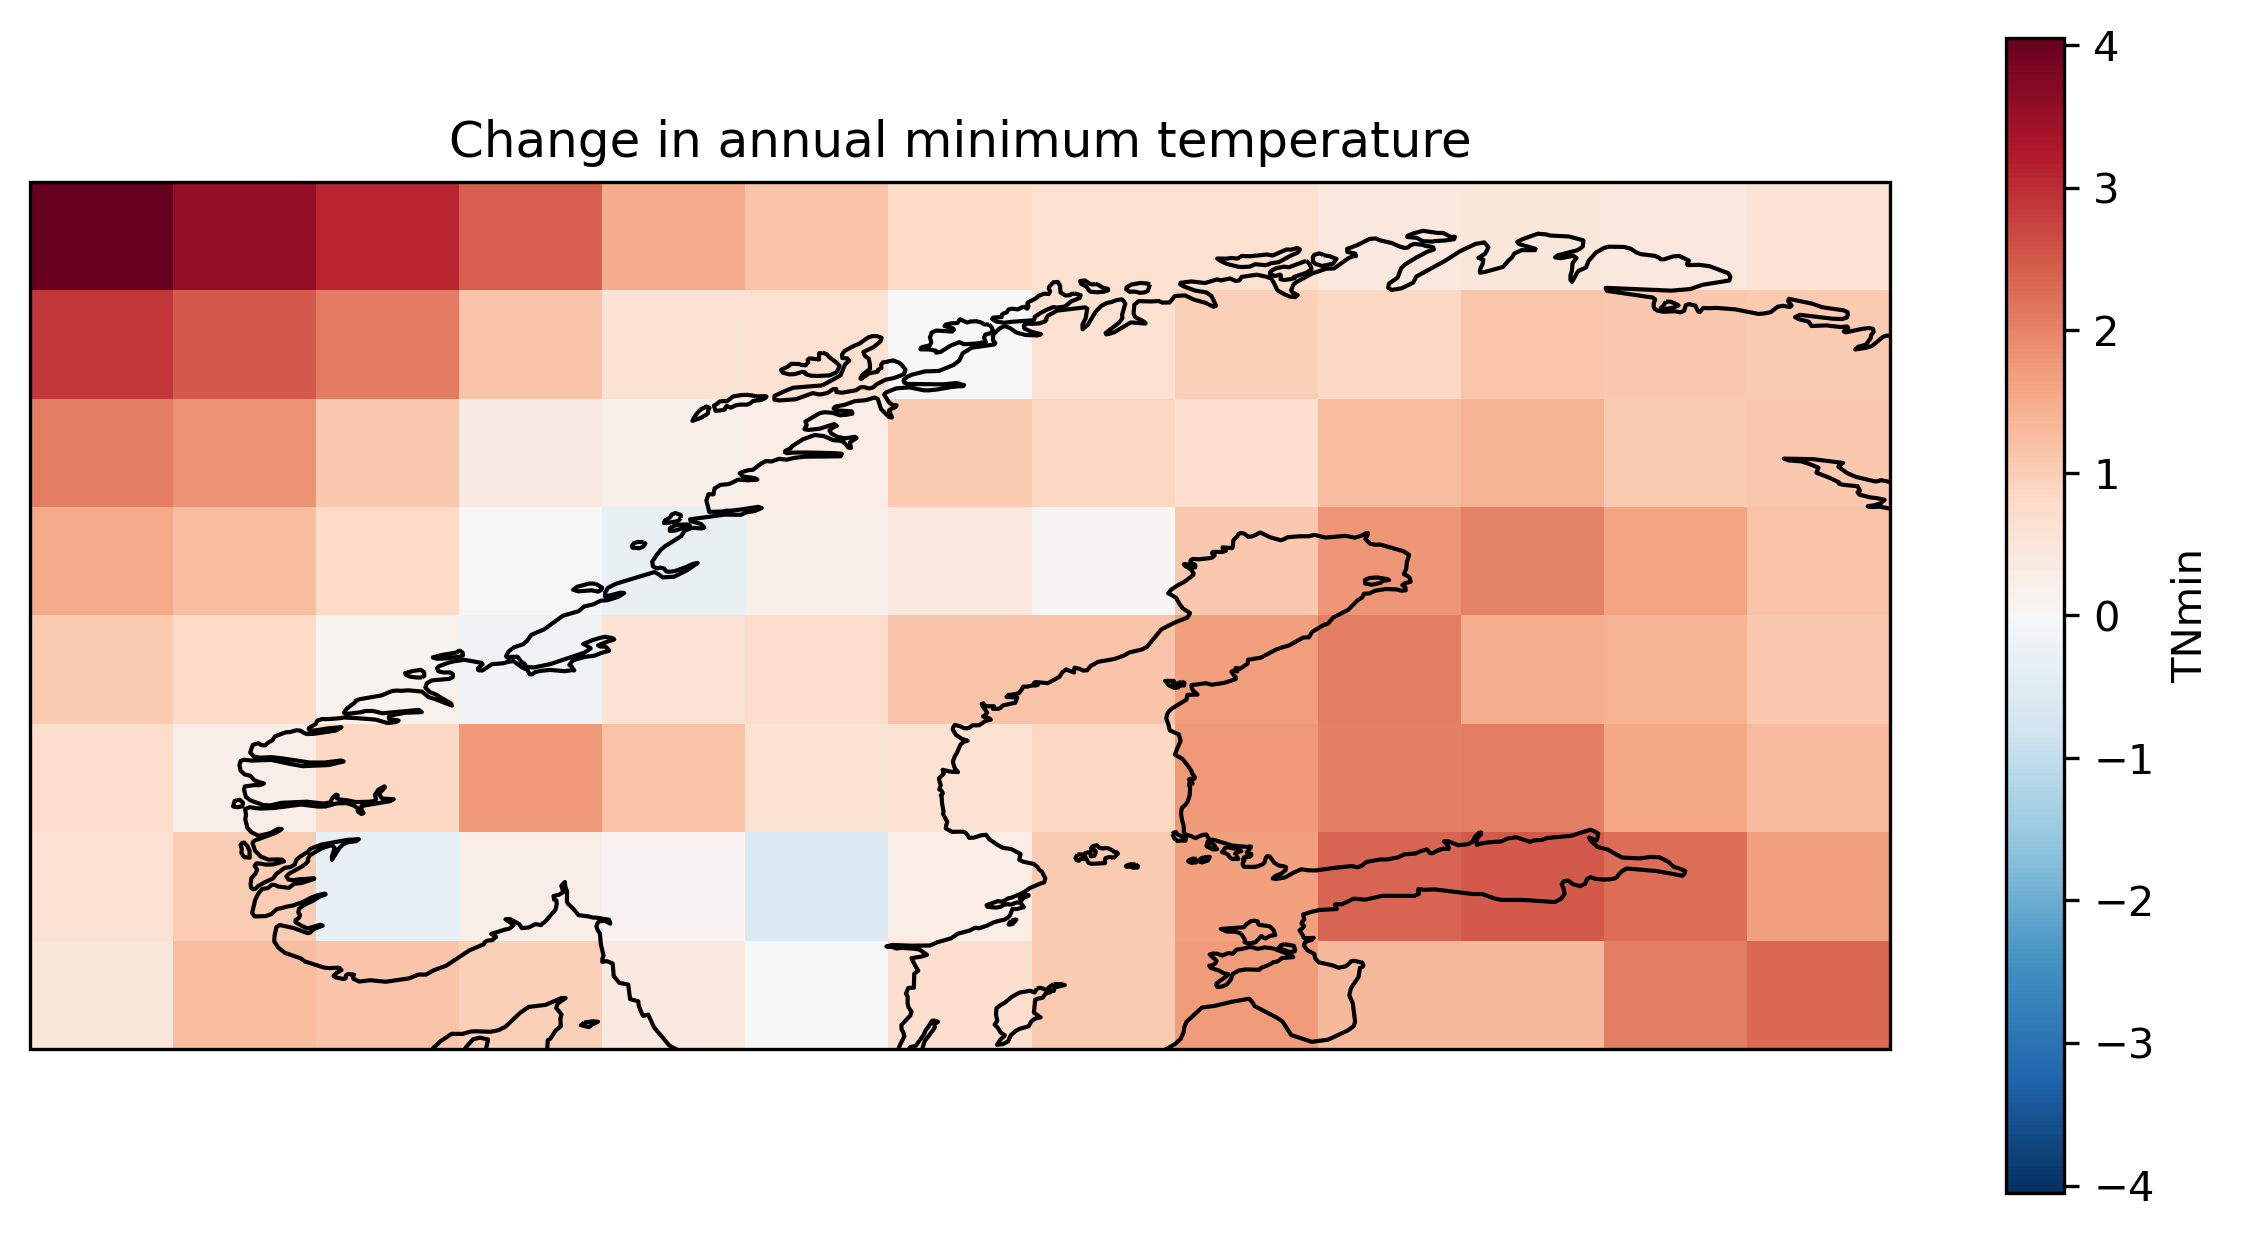

41


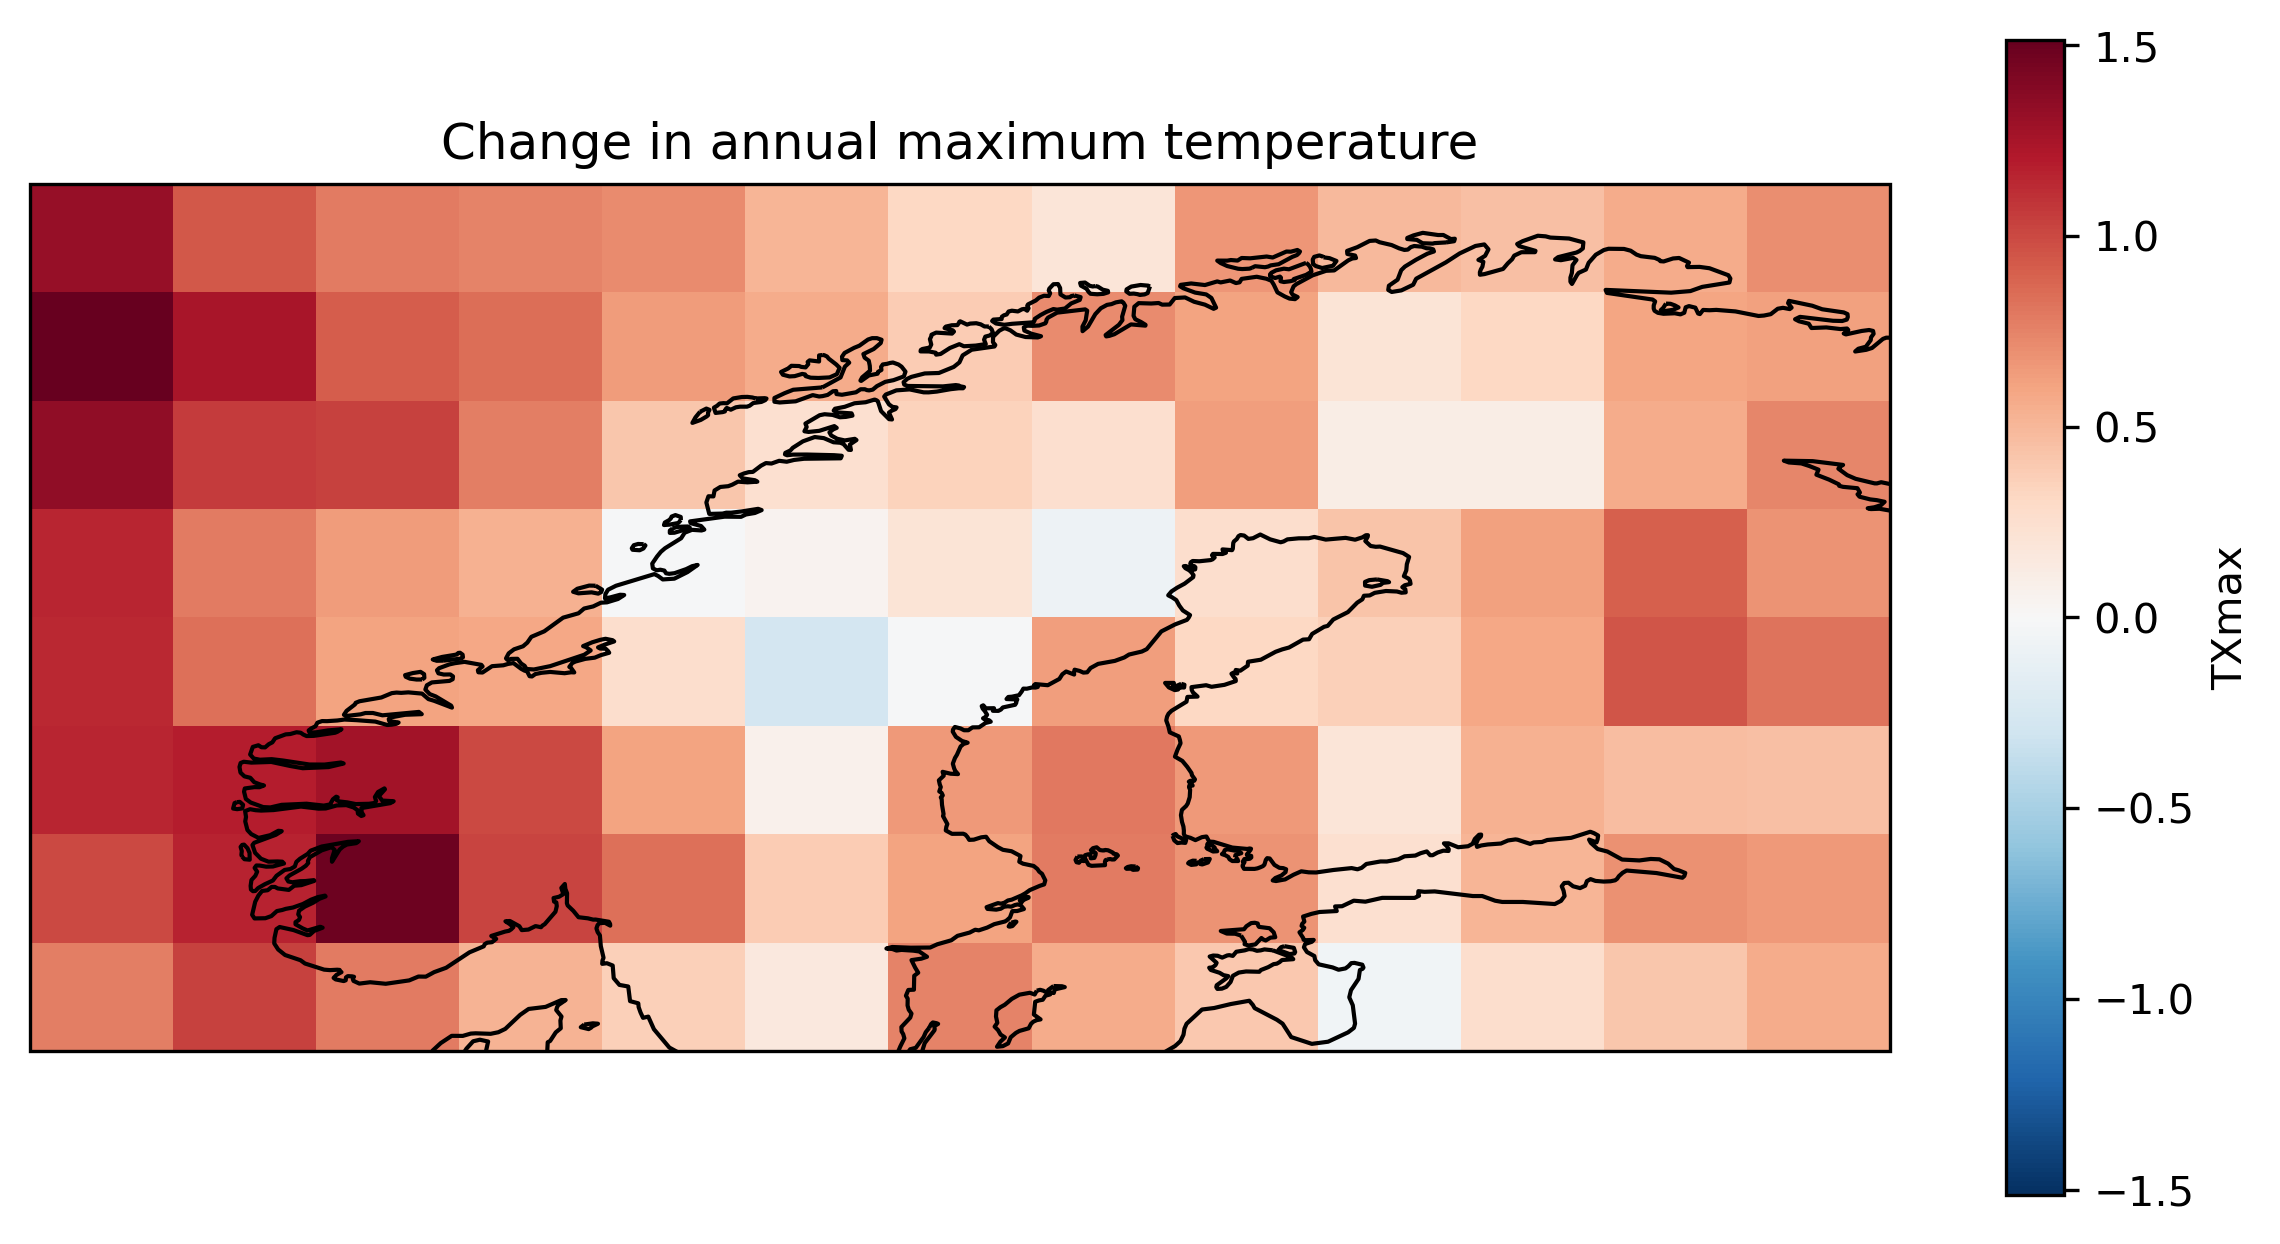

In [ ]:
ds = xr.open_dataset(save_folder+'TNmin_'+area_name+'_'+model_scenario_name+'.nc')
data = ds.TNmin
print(data.values)
fig = plt.figure(1, figsize=(10,5),dpi=300)
ax = plt.subplot(1,1,1, projection=ccrs.PlateCarree())
diff = data.isel(time=slice(20,40)).mean("time") - data.isel(time=slice(0,20)).mean("time")
map = diff.plot(ax=ax, 
                transform=ccrs.PlateCarree())
ax.coastlines()
ax.set_title("Change in annual minimum temperature")
plt.show()
fig.clear()

ds = xr.open_dataset(save_folder+'TXmax_'+area_name+'_'+model_scenario_name+'.nc')
data = ds.TXmax
fig = plt.figure(1, figsize=(10,5),dpi=300)
ax = plt.subplot(1,1,1, projection=ccrs.PlateCarree())
diff = data.isel(time=slice(20,40)).mean("time") - data.isel(time=slice(0,20)).mean("time")
map = diff.plot(ax=ax, 
                transform=ccrs.PlateCarree())
ax.coastlines()
ax.set_title("Change in annual maximum temperature")